In [89]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
% matplotlib inline
import math
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import time

# I The framework

In the report you should first describe the article on such a level of detail that your peer students in this course understand the method, and so that it is clear to the reader that you understand the method too.

Linear PCA consists in a orthogonal basis transformation that can be used for dimensionality reduction. In the context of de-noising it is very limited: indeed it can only de-noise linear patterns as we shall show in the experiments. Kernel PCA solves this limitation. It makes use of a function $\Phi$ that maps that data from the input space (typically $\mathbb{R}^N$) to a feature space. The feature space is typically of much higher dimension than the input space, for the gaussian kernel on which we will focus the feature space is of infinite dimension. Linear PCA is performed in the feature space. The transformation is linear in the feature space but non-linear in the input space.Data in the feature space is projected onto the main principal components. The difficult part is to take these projections back to the input, this is called the pre-image problem and it is the major contribution of this paper to propose an algorithm to solve this problem.
In the original paper the authors have used this method in the purpose of de-noising.

Let $x$ be a test point. $\{x_i\}$_{i=1}^l are the "train" data. $\{V^k\}$ are the eigeinvectors of the covariance matrix $\bar{\mathbf{C}}$. If we suppose the $\Phi$-images of the train data to be centered (in the feature space), the covariance matrix is $\bar{\mathbf{C}}=\frac{1}{l}\sum_{k=1}^l\Phi(x_k)\Phi(x_k)^T$, so an eigenvector $V$ with eigenvalue $\lambda$ satisfies 
$\bar{\mathbf{C}}V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l(\Phi(x_k)\Phi(x_k)^T)V=\lambda V$, 
i.e $\frac{1}{l}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)=\lambda V$
For non-zero eigenvalue $\lambda$ we have:
$V=\frac{1}{l\lambda}\sum_{k=1}^l\underbrace{(\Phi(x_k)\cdot V)}_{scalar}\Phi(x_k)$
So $V$ is a linear combination of the $\Phi$-images of the training data, there exist coefficients $\{\alpha_i\}_{i=1}^l$ such that $V=\sum_{i=1}^l\alpha_i \Phi(x_i)$. Now let's see how to actually compute these coefficients $\alpha_i$. The equation $\lambda V=\bar{\mathbf{C}}V$ can be written in $l$ scalar equations 
$$\forall j \in \{1,\dots,l\} \lambda(V \cdot \Phi(x_j))=(\bar{\mathbf{C}}V\cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l(\Phi(x_k) \Phi(x_k)^T)\sum_{i=1}^l\alpha_i\Phi(x_i)\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\Big[\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i\underbrace{(\Phi(x_k) \Phi(x_k)^T)\Phi(x_i)}_{(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k)}\Big] \cdot \Phi(x_j))$$
$$\lambda (\sum_{i=1}^l\alpha_i\Phi(x_i) \cdot \Phi(x_j))=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_i(\Phi(x_k)\cdot \Phi(x_i))\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=(\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)\Phi(x_k) \cdot \Phi(x_j))$$
$$\lambda \sum_{i=1}^l\alpha_ik(x_i, x_j)=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_ik(x_i, x_k)k(x_k, x_j)$$
$$\lambda \sum_{i=1}^l\alpha_iK_{ij}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda \sum_{i=1}^l\alpha_i\underbrace{K_{ij}}_{=K_{ji} \text{because K symmetric}}=\frac{1}{l}\sum_{k=1}^l\sum_{i=1}^l\alpha_iK_{ik}K_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}\sum_{k=1}^l(K\alpha)_kK_{kj}$$
$$\lambda (K\alpha)_j = \frac{1}{l}(KK\alpha)_j$$
So in a vector form we have:
$$\lambda K\alpha = \frac{1}{l}K^2\alpha$$
$$l \lambda K \alpha = K^2 \alpha$$
$$l \lambda \alpha = K \alpha$$
So
* The eigenvectors $V^k$ (with associated eigenvalues $\lambda^k$) can be written as $V^k=\sum_{i=1}^l\alpha_i^k\Phi(x_i)$ and the vector $\alpha^k=(\alpha_1^k, \dots, \alpha_l^k)^T$ is an eigenvector of the kernel matrix $K$ with eigenvalue $l \lambda^k$
* Projections of the test point $x$ on the $V^k$: $\beta_k=\sum_{i=1}^l\alpha_i^kk(x,x_i)$, only depends on the test point $x$ and the training data $\{x_i\}_{i=1}^l$, does not depend on the sequence $z_0, \dots, z_t, \dots$
* Let $n$ be the number of principal components and $P_n$ the operator that project the $\Phi$-image of the test point $\Phi(x)$ onto the span of the eigenvectors $\{V^k\}_{k=1}^n$, 
$P_n(\Phi(x))=\sum_{k=1}^n(\Phi(x)\cdot V^k)V^k
             =\sum_{k=1}^n\beta_k V^k$
* Pre-image problem: the main difficulty is to find the pre-image of this projected vector $P_n(\Phi(x))$, that is to say find the vector $z$ in the input space such that $\Phi(z)=P_n(\Phi(x))$. We do not know anything about the mapping $\Phi$ from the input space to the feature space, it is probably not injective and as a consequence there may not exist such a vector $z$ in the input space such that its $\Phi$-image is the projected vector $P_n(\Phi(x))$. So we have to find an approximation of the pre-image of $P_n(\Phi(x))$ so a vector $z$ such that the quantity
$\rho(z)=||\Phi(z) - P_n(\Phi(x))||^2$ is minimal. If the kernel is gaussian, that is to say in the form $k(x,y)=\exp(-||x-y||^2/c)$ (with $c\neq 0$) we can find an iterative scheme to minimize $\rho(z)$
* Let's expand the square in $\rho(z)$:
$$\rho(z) = ||\Phi(z)||^2 - 2(\Phi(z) \cdot P_n(\Phi(x))) + ||P_n(\Phi(x)||^2$$
$$\rho(z) = k(z, z) - 2\Phi(z) \cdot \sum_{k=1}^n\beta_k \sum_{i=1}^l\alpha_i^k\Phi(x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
$$\rho(z) = \underbrace{k(z, z)}_{constant} - 2\sum_{k=1}^n\beta_k \sum_{i=1}^l\alpha_i^k\Phi(z) \cdot \Phi(x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
$$\rho(z) = \underbrace{k(z, z)}_{constant} - 2\sum_{i=1}^l\sum_{k=1}^n\beta_k \alpha_i^k k(z,x_i) + \underbrace{||P_n(\Phi(x)||^2}_{\text{does not depend on }z}$$
Let's denote $\forall i \in \{1, \dots, l\}, \gamma_i=\sum_{k=1}^n\beta_k \alpha_i^k$ and $\Omega$ the terms that are constant with respect to $z$, that is $\Omega=k(z,z) + ||P_n(\Phi(x))||^2$, we have
$$\rho(z) = -2\sum_{i=1}^l\gamma_i k(z,x_i) + \Omega$$
Finally let's define $\rho^{\prime}(z) = \sum_{i=1}^l\gamma_i k(z,x_i)$. Minimizing $\rho(z)$ is the same as maximizing $\rho^{\prime}(z)$. Let $z^*$ be the maximum of $\rho^{\prime}(z)$, a necessary condition is the derivate of $\nabla_z(\rho^{\prime}(z^*))=0$. Let's compute this derivative:
$$\rho^{\prime}(z) = \sum_{i=1}^l\gamma_i k(z,x_i)$$
$$\nabla_z(\rho^{\prime})(z) = \sum_{i=1}^l\gamma_i \frac{\partial ||z-x_i||^2}{\partial z}k^{\prime}(||z-x_i||^2)$$
We have 
$$\frac{\partial ||z-x_i||^2}{\partial z} = 2(z-x_i)$$
and $k^{\prime}(||z-x_i||^2)$ denotes the derivate of the real function $f(y)=e^{-y/c}$ taken at $y=||z-x_i||^2$ so $k^{\prime}(||z-x_i||^2)=-\frac{1}{c}\exp(-\frac{||z-x_i||^2}{c})=-\frac{1}{c}k(z, x_i)$ and we have:
$$\nabla_z(\rho^{\prime}(z))=-\frac{2}{c}\sum_{i=1}^l\gamma_i(z-x_i)k(z,x_i)$$
Setting the derivative to zero we obtain:
$$\sum_{i=1}^l\gamma_i(z^*-x_i)k(z^*,x_i)=0$$
$$z^*=\frac{\sum_{i=1}^l\gamma_i x_i k(z^*,x_i)}{\sum_{i=1}^l\gamma_i k(z^*,x_i)}$$
* Iteration scheme: 
$$z_{t+1}=\frac{\sum_{i=1}^l\gamma_i x_i \exp(-\frac{||z_t-x_i||^2}{c})}{\sum_{i=1}^l\gamma_i exp(-\frac{||z_t-x_i||^2}{c})}$$
We can start with the test point: $z_0 = x$
* $\gamma_i = \sum_{k=1}^n\beta^k \alpha_i^k$, depends on the projections of the test point $x$ on the eigenvectors $V^k$ of the covariance matrix $\bar{\mathbf{C}}$ of the training data samples $\{x_i\}_{i=1}^l$ and on the coordinates of these eigenvectors $V^k$ in the span of the $\Phi$-images of the training data samples $\{\Phi(x_i)\}_{i=1}^l$, does not depend on the sequence $z_0, \dots, z_t, \dots$

In [310]:
def gaussianKernel(x, y, c):
    ''' Returns K(x,y) where K denotes gaussian kernel '''
    return math.exp(-(np.linalg.norm(x-y)**2) / c)

def createK(data, kernelFunction, c):
    ''' Returns K matrix containing inner products of the data using the kernel function 
        so that K_ij := (phi(x_i)*phi(x_j)) '''
    l = len(data)
    K = np.zeros((l,l))
    for col in range(l):
        for row in range(l):
            K[row][col] = kernelFunction(data[row],data[col], c)
    return K

def calcBetaK(alphaK, kernelFunction, data, x, c):
    ''' Returns the projection of x onto the eigenvector V_k '''
    betaK = 0
    for i,xi in enumerate(data):
        betaK += alphaK[i]*kernelFunction(xi,x,c)
    return betaK

def centerK(K):
    ''' Returns centered K matrix, see K. Murphy 14.43 '''
    l = len(K)
    l_ones = np.ones((l, l), dtype=int) / l
    Kcentered = K - np.dot(l_ones,K)-np.dot(K,l_ones)+np.dot(l_ones,np.dot(K,l_ones))
    return Kcentered

def normAlpha(alpha, lambdas):
    ''' Returns new alpha corresponding to normalized eigen vectors,
        so that lambda_k(a^k * a^k) = 1 '''
    for i,a in enumerate(alpha):
        a /= np.sqrt(lambdas[i])
    return alpha

def calcZ(alpha, data, x, kernelFunction, c, z0, maxIters):
    ''' Equation (10), returns pre-image z for single input datapoint x '''
    z = z0
    zNew = np.random.multivariate_normal(np.zeros(z0.size), np.identity(z0.size))
    iters=0
    # calculate beta (does not change with each iteration)
    beta = [calcBetaK(aK, kernelFunction, data, x, c) for aK in alpha]
    # gamma does not change with each iteration neither
    gamma = [calcGammaIOpt(alpha, i, beta) for i in range(len(data))]
    
    while iters < maxIters:
        numerator = 0
        denom = 0
        for i, xi in enumerate(data):
            gammaI = gamma[i] * kernelFunction(z,xi,c)
            numerator += gammaI * xi
            denom += gammaI
        if denom!=0: #handling numerical instability
            z = zNew
            zNew = numerator/denom
            iters +=1
        else:
            print("instability", "z", z, "x", x, "numerator", numerator)
            iters =0
            z=z0 + np.random.multivariate_normal(np.zeros(z0.size), np.identity(z0.size))
            numerator = 0
            denom = 0
    return zNew

def calcGammaIOpt(alpha, i, beta):
    ''' returns gamma_i = sum_{k=1}^n beta_k * alpha_i^k '''
    gammaI = 0
    alphaI = alpha.T[i]
    for k, alphaKI in enumerate(alphaI):
        gammaI += beta[k] * alphaKI
    return gammaI

def myPCA(data, X, n):
    l, d = data.shape
    C = np.zeros((d, d))
    m = np.mean(data, axis=0)
    for xi in data-m:
        C += 1/l*np.dot(xi.reshape((d, 1)), xi.reshape((d, 1)).T)
    lambdas, v = np.linalg.eigh(C)
    Z = np.zeros(X.shape) # result
    for i, xi in enumerate(X-m):
        Z[i] = m+np.sum(np.array([np.dot(xi, vi)*vi for vi in v[-n:]]), axis=0)
    return Z

def myKPCA(data, test, n, maxIters, c):
    l = len(data)
    K = centerK(createK(data, gaussianKernel, c))
    lambdas, alphas = np.linalg.eigh(K)
    lambdas = lambdas/l
    lambdas, alphas = lambdas[-n:], alphas[-n:]
    alphas = normAlpha(alphas, lambdas)
    Z = np.zeros(test.shape) # result
    for i, xi in enumerate(test):
        Z[i] = calcZ(alphas, data, xi, gaussianKernel, c, xi, maxIters)
    return Z

def skPCA(data, X, n):
    pca = PCA(n_components=n)
    pca.fit(data)
    return pca.inverse_transform(pca.transform(X))

def skKPCA(data, X, n, c):
    kpca = KernelPCA(n_components=n, kernel="rbf", fit_inverse_transform=True, kernel_params=c)
    kpca.fit(data)
    return kpca.inverse_transform(kpca.transform(X))

def error(Z, center):
    err = 0
    for z in Z:
        err += np.linalg.norm(z-center)**2
    return err

## II Eleven gaussians in $\mathbb{R}^{10}$
Dataset:
* we generated a data set from eleven Gaussians in $\mathbb{R}^{10}$ with "zero" mean and variance $\sigma^2$ in each component
* selecting from each source $100$ points as a training set and $33$ points for a test set 
* centers of the Gaussians randomly chosen in $[-1, 1]^{10}$

## 1) Let's start in $\mathbb{R}^2$

Generate some 2D data
* $2$ random centers 
* $100$ samples for train, $33$ for test, for each center
* std dev: $\sigma= 0.05, 0.1, 0.2, 0.4, 0.8$

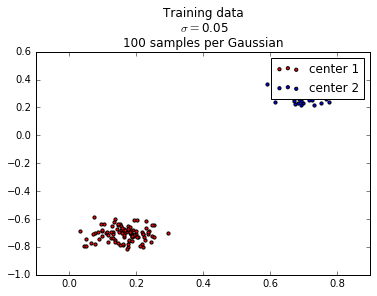

In [303]:
sigmas = np.array([0.05, 0.1, 0.2, 0.4, 0.8])
nTrain, nTest = 100, 33
n, sigmaIdx = 1, 0
centers = np.random.uniform(-1, 1, size=(2, 2))
Xtrain1 = np.array([np.random.multivariate_normal(centers[0], s**2*np.identity(2), size=nTrain) for s in sigmas])
Xtest1 = np.array([np.random.multivariate_normal(centers[0], s**2*np.identity(2), size=nTest) for s in sigmas])
Xtrain2 = np.array([np.random.multivariate_normal(centers[1], s**2*np.identity(2), size=nTrain) for s in sigmas])
Xtest2= np.array([np.random.multivariate_normal(centers[1], s**2*np.identity(2), size=nTest) for s in sigmas])
plt.scatter(Xtrain1[sigmaIdx][:, 0], Xtrain1[sigmaIdx][:, 1], c="r", s=10, label="center 1")
plt.scatter(Xtrain2[sigmaIdx][:, 0], Xtrain2[sigmaIdx][:, 1], c="b", s=10, label="center 2")
plt.title("Training data\n $\sigma=$" + str(sigmas[sigmaIdx]) + "\n" + str(len(Xtrain)) + " samples per Gaussian")
plt.legend()

## 2) Linear PCA

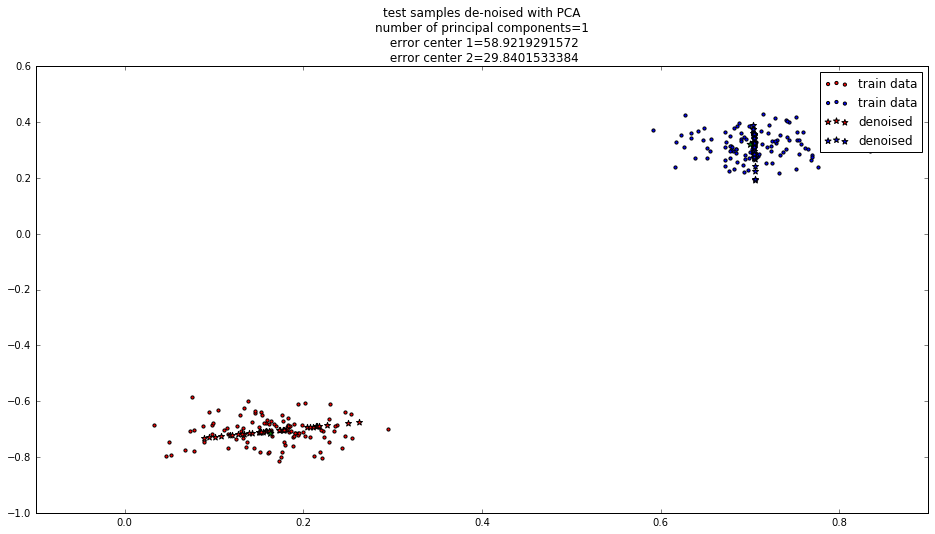

In [304]:
plt.figure(figsize=(16, 8))
Zpca1 = myPCA(Xtrain1[sigmaIdx], Xtest1[sigmaIdx], n)
Zpca2 = myPCA(Xtrain2[sigmaIdx], Xtest2[sigmaIdx], n)

plt.scatter(Xtrain1[sigmaIdx][:, 0], Xtrain1[sigmaIdx][:, 1], c="r", s=10, label="train data")
plt.scatter(Xtrain2[sigmaIdx][:, 0], Xtrain2[sigmaIdx][:, 1], c="b", s=10, label="train data")
plt.scatter(Zpca1[:, 0], Zpca1[:, 1], c="r", marker="*", s=40, label="denoised")
plt.scatter(Zpca2[:, 0], Zpca2[:, 1], c="b", marker="*", s=40, label="denoised")
plt.scatter(centers[0][0], centers[0][1], c="g", marker="*", s=50)
plt.scatter(centers[1][0], centers[1][1], c="g", marker="*", s=50)
plt.title("test samples de-noised with PCA\n"+
          "number of principal components=" + str(n) +
          "\n error center 1=" + str(error(Zpca1, center)) + 
          "\n error center 2=" + str(error(Zpca2, center)))
plt.legend()

## 3) Kernel PCA

instability z [ 1.18092347  2.3859128 ] x [ 0.22957792 -0.72437222] numerator [ 0.  0.]
instability z [-2.07122104 -1.46582383] x [ 0.67703551  0.31597578] numerator [ 0.  0.]
instability z [-3.22487988 -0.59368021] x [ 0.67642817  0.19289975] numerator [ 0.  0.]
instability z [-2.40268174 -0.33247278] x [ 0.7589542   0.32674927] numerator [ 0.  0.]
instability z [-2.12120378 -0.61088945] x [ 0.67377417  0.34140113] numerator [ 0.  0.]


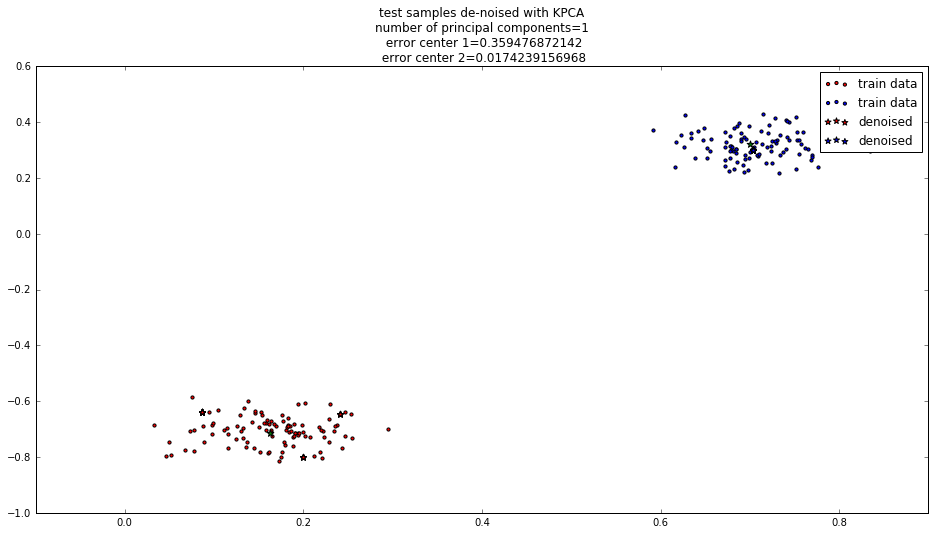

In [305]:
plt.figure(figsize=(16, 8))
maxIters = 100
c = 2*2*sigmas[sigmaIdx]**2
Zkpca1 = myKPCA(Xtrain1[sigmaIdx], Xtest1[sigmaIdx], n, maxIters, c)
Zkpca2 = myKPCA(Xtrain2[sigmaIdx], Xtest2[sigmaIdx], n, maxIters, c)

plt.scatter(Xtrain1[sigmaIdx][:, 0], Xtrain1[sigmaIdx][:, 1], c="r", s=10, label="train data")
plt.scatter(Xtrain2[sigmaIdx][:, 0], Xtrain2[sigmaIdx][:, 1], c="b", s=10, label="train data")
plt.scatter(Zkpca1[:, 0], Zkpca1[:, 1], c="r", marker="*", s=40, label="denoised")
plt.scatter(Zkpca2[:, 0], Zkpca2[:, 1], c="b", marker="*", s=40, label="denoised")
plt.scatter(centers[0][0], centers[0][1], c="g", marker="*", s=50)
plt.scatter(centers[1][0], centers[1][1], c="g", marker="*", s=50)
plt.title("test samples de-noised with Kernel PCA\n" + 
          "number of principal components=" + str(n) +
          "\n error center 1=" + str(error(Zkpca1, centers[0])) + 
          "\n error center 2=" + str(error(Zkpca2, centers[1])))
plt.legend()

## 4) Pre-images from initialisation to convergence

some 2D data

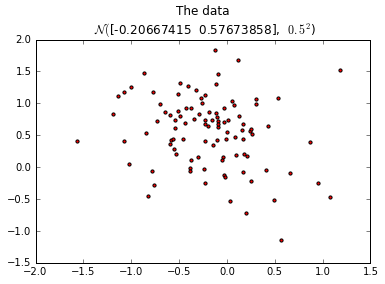

In [264]:
sigma = 0.5
center = np.random.uniform(-1, 1, size=2)
Xtrain = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=100)
Xtest = np.random.multivariate_normal(center, sigma**2*np.identity(2), size=33)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10)
plt.title("The data\n $\mathcal{N}($" + str(center) +  ",  $0.5^2$)")

Let's see how the sequence $z_t$ evolves. And also check if convergence is reached at the same point across different random starting points.

[[-0.13792396407344198, -1.0039262856696489]]


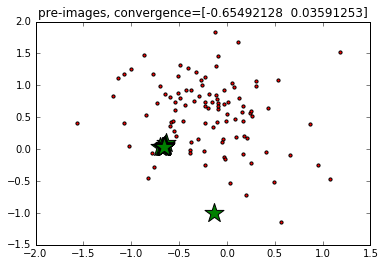

In [277]:
z = [list(np.random.multivariate_normal([0, 0], sigma**2*np.identity(2)))]
print(z) # the random starting point
n = 1 # n components for reconstruction
z0 = z # in case of numerical instability
iters=0
maxIters = 30 # number of iterations
c = 2*2*sigma**2
Data = Xtrain
x = Xtest[0]
K = centerK(createK(Data, gaussianKernel, c))
lLambda, alpha = np.linalg.eigh(K) 
lambdas = lLambda/l 
lambdas=lambdas[-n:]
alpha=alpha[-n:]
alpha = normAlpha(alpha, lambdas)

beta = [calcBetaK(aK, gaussianKernel, Xtrain, x, c) for aK in alpha]
gamma = [calcGammaIOpt(alpha, i, beta) for i in range(len(Xtrain))]

while iters < maxIters:
    numerator = 0
    denom = 0
    for i, xi in enumerate(Xtrain):
        gammaI = gamma[i] * gaussianKernel(z[-1], xi, c)
        numerator += gammaI * xi
        denom += gammaI
    if denom!=0: #handling numerical instability
        z.append(numerator/denom)
        iters +=1
    else:
        print("---", "instability", denom, "---")
        iters = 0
        z = list(z0 + np.random.multivariate_normal(np.zeros(z0.size), np.identity(z0.size)))
        numerator = 0
        denom = 0
        
z = np.array(z)
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c="r", s=10, label="the data")
plt.scatter(z[:, 0], z[:, 1], c="g", s=400, marker="*", label="z")
plt.title("pre-images, convergence=" + str(z[-1]))

## 3) Now the real thing in $\mathbb{R}^{10}$

Generate data in $\mathbb{R}^{10}$

In [307]:
sigma = np.array([0.05, 0.1, 0.2, 0.4, 0.8])
centers = np.random.uniform(-1, 1, size=(11, 10))
Xtrain = np.array([[np.random.multivariate_normal(center, s**2*np.identity(10), size=100) for center in centers] for s in sigma])
Xtest = np.array([[np.random.multivariate_normal(center, s**2*np.identity(10), size=33) for center in centers] for s in sigma]) 
print(Xtrain.shape)

(5, 11, 100, 10)


In [308]:
maxIters = 10
def ratio(sigmaIdx, n):
    c = 10*2*sigma[sigmaIdx]**2
    errorKPCA = 0
    errorPCA = 0
    for idx, center in enumerate(centers):
        Data = Xtrain[sigmaIdx][idx]
        Test = Xtest[sigmaIdx][idx]

        Zpca = myPCA(Data, Test, n)
        Zkpca = myKPCA(Data, Test, n, c, maxIters)
        errorPCA = error(Zpca, center)
        errorKPCA = error(Zkpca, center)
    ratio = errorPCA/errorKPCA
    print(sigma[sigmaIdx], n, errorPCA, errorKPCA, ratio)
for n in range(1, 10):
    ratio(0, n)

0.05 1 0.116311264891 0.872459844712 0.133314175542
0.05 2 0.191736212407 0.68906832826 0.278254281243
0.05 3 0.295131938523 0.109297774587 2.70025569723
0.05 4 0.356011588596 0.0930281864432 3.82692173424
0.05 5 0.428950796036 0.0799888301379 5.36263369893
0.05 6 0.47976299687 0.0681970331406 7.03495408489
0.05 7 0.548484700614 0.10418398935 5.26457763842
0.05 8 0.635397893276 0.109005262677 5.82905703515
0.05 9 0.712677214793 0.111135101658 6.41271033328


### Test the implementation of pca

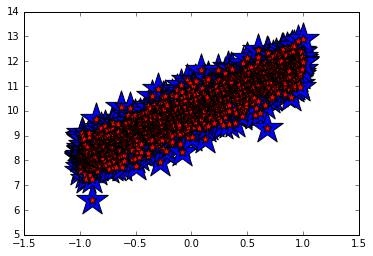

In [309]:
Data = np.array([[x, 2*x+10+np.random.normal(0, 0.5)] for x in np.linspace(-1, 1, 1000)])
plt.scatter(Data[:, 0], Data[:, 1], c="r", s=10, label="training data")
Z = myPCA(Data, Data, 2)
plt.scatter(Z[:, 0], Z[:, 1], c="b", s=1100, marker="*")
plt.scatter(Data[:, 0], Z[:, 1], c="r", s=100, marker="*")